In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pubchempy
import pandas as pd
from itertools import compress
import seaborn as sns
from matchms.importing import load_from_mgf

from rdkit import Chem
from rdkit.Chem import Draw


from matchms import calculate_scores
from matchms.plotting.spectrum_plots import plot_spectra_mirror, plot_spectrum


from matplotlib import animation, rc
from celluloid import Camera # getting the camera
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

from SpectralPerturbation import perturb_spetrum_copy

from matchms import calculate_scores
from matchms.similarity import CosineGreedy
from matchms.similarity import ModifiedCosine
import random


random.seed(42)
np.random.seed(42)


In [2]:
path_data = "../data"

print("Load reference and query data.")
file_mgf_reference = os.path.join(path_data, "ex_spectra_stds_NEG_scans_50.mgf")
reference_spectra = list(load_from_mgf(file_mgf_reference))

file_mgf_query = os.path.join(path_data, "pseudo_query_neg_v1.mgf")
query_spectra = list(load_from_mgf(file_mgf_query))

print(f"Detected {len(reference_spectra)} reference spectra and {len(query_spectra)} query spectra.")

Load reference and query data.
Detected 968 reference spectra and 1614 query spectra.


<AxesSubplot: title={'center': 'Spectrum'}, xlabel='m/z', ylabel='Intensity'>

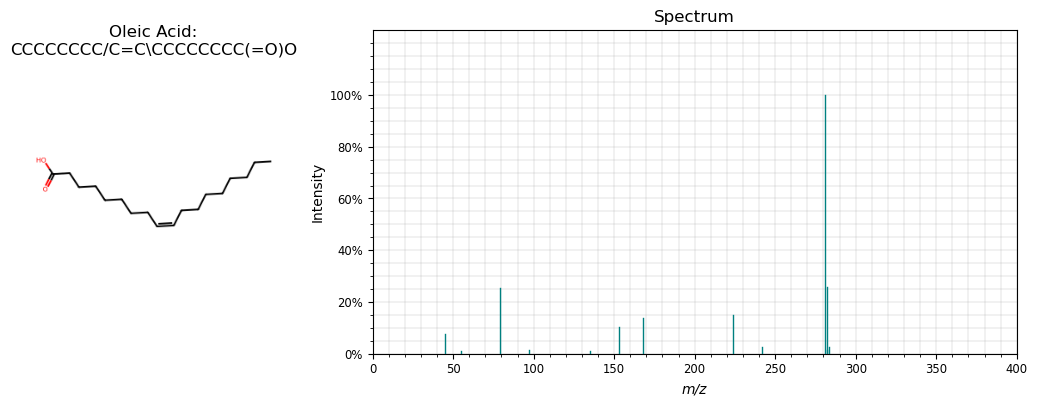

In [3]:
example_query_number = 1394
example_spectrum = query_spectra[example_query_number]
example_smiles = "CCCCCCCC/C=C\CCCCCCCC(=O)O"

fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.2), gridspec_kw={'width_ratios': [2, 5]}, sharey=False)


# Compound
img = Chem.Draw.MolToImage(Chem.MolFromSmiles(example_smiles), ax=axs[0])

axs[0].grid(False)
axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False)
axs[0].set_title("Oleic Acid:\n" + example_smiles)
axs[0].imshow(img)
axs[0].axis("off")

# Spectrum
plot_spectrum(example_spectrum, axs[1])

### Perturbation to peak intenity

Now, let's add some random perturbation to all peaks. The implementation of the perturbation follows Toprak *et. al.* (2014) with perturbation strength *r*, which randomnly sampled from a specified perturbation range, e.g. 0.25 to 0.5. This effect of the perturbations are shown below.


In [4]:
similarity_measure = CosineGreedy(tolerance=0.005)

In [5]:
%%capture

fig, ax = plt.subplots(1, 1, figsize=(12.8, 4.2))
perturb_range = [0.25, 0.5]



# Spectrum animation
camera = Camera(fig)# the camera gets our figure

# Original spectrum
plot_spectrum(example_spectrum, ax)
ax.text(1, 1.2, f"Original spectrum") # Dynamic subtext

camera.snap()

for i in range(9):
    # Create perturbed copy of the spectrum
    spectrum = perturb_spetrum_copy(example_spectrum, perturb_range)
    
    # 
    cosine_scores = calculate_scores([example_spectrum], [spectrum], similarity_measure, is_symmetric=False)
    match = cosine_scores.scores_by_query(spectrum, sort=True)[0][1]
    cosine = match.tolist()[0]
        
    plot_spectrum(spectrum, ax)
    #ax.text(1, 1.2, f"Perturbation Level: {perturb_range[0] * 100}% to {perturb_range[1] * 100}%")
    ax.text(1, 1.2, f"Cosine similarity: {cosine:.2f}")

    plt.title(f"Effect of a moderate level of peak ({perturb_range[0] * 100}% to {perturb_range[1] * 100}%)")
    camera.snap()

animation = camera.animate(blit=False, interval=600)
rc('animation', html='html5')

In [6]:
#HTML(animation.to_html5_video())
animation.save('spectrum_moderate_perturbation.gif')

![GIF](spectrum_moderate_perturbation.gif "segment")


Let's crank up the perturbation


In [7]:
%%capture

fig, ax = plt.subplots(1, 1, figsize=(12.8, 4.2))
perturb_range = [0.5, 0.75]



# Spectrum animation
camera = Camera(fig)# the camera gets our figure

# Original spectrum
plot_spectrum(example_spectrum, ax)
ax.text(1, 1.2, f"Original spectrum") # Dynamic subtext

camera.snap()

for i in range(9):
    # Create perturbed copy of the spectrum
    spectrum = perturb_spetrum_copy(example_spectrum, perturb_range)
    
    # 
    cosine_scores = calculate_scores([example_spectrum], [spectrum], similarity_measure, is_symmetric=False)
    match = cosine_scores.scores_by_query(spectrum, sort=True)[0][1]
    cosine = match.tolist()[0]
        
    plot_spectrum(spectrum, ax)
    #ax.text(1, 1.2, f"Perturbation Level: {perturb_range[0] * 100}% to {perturb_range[1] * 100}%")
    ax.text(1, 1.2, f"Cosine similarity: {cosine:.2f}")

    plt.title(f"Effect of a high level of peak ({perturb_range[0] * 100}% to {perturb_range[1] * 100}%)")
    camera.snap()

animation = camera.animate(blit=False, interval=600)
rc('animation', html='html5')

In [8]:
#TML(animation.to_html5_video())
animation.save('spectrum_high_perturbation.gif')

![GIF](spectrum_high_perturbation.gif "segment")